### 4.3 A Gaussian model of height

In [1]:
import pandas as pd
import numpy as np
import arviz as az  #ArviZ: Exploratory analysis of Bayesian models
import matplotlib.pyplot as plt
from scipy.stats import norm, uniform
import seaborn as sns
import pymc3 as pm

##### load the data and create a subset (code 4.10)

In [2]:
df = pd.read_csv('../Data/Howell1.csv', sep=';', header=0)
df.head()
df2 = df[df.age >=18]

In [3]:
#df2.sort_values('age').head()

##### kde of height

Text(0.5, 0, 'Height')

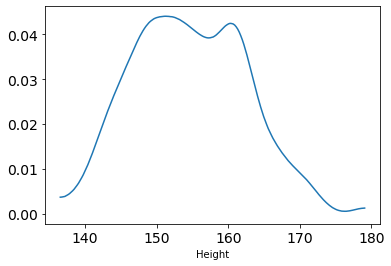

In [4]:
az.plot_kde(df2.height)
plt.xlabel('Height')

##### code 4.11

In [5]:
x = np.linspace(100, 250, num=1000)
y = norm.pdf(x, loc=178, scale=20)

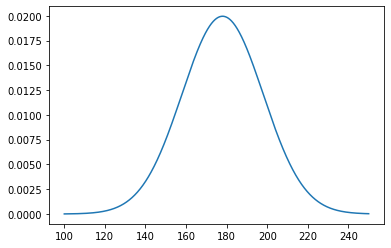

In [6]:
plt.plot(x, y)
plt.show()

##### code 4.12

In [7]:
x = np.linspace(-10, 60, num=100)
y = uniform.pdf(x, loc=0, scale=50)

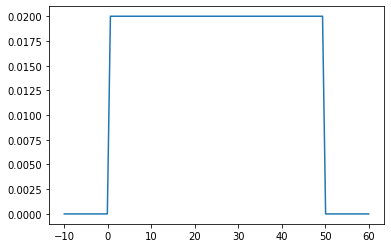

In [8]:
plt.plot(x, y)
plt.show()

##### code 4.13

In [9]:
sample_mu = norm.rvs(loc=178, scale=20, size=int(1e4), random_state=110)
sample_sigma = uniform.rvs(loc=0, scale=50, size=int(1e4), random_state=110)

In [10]:
prior_h = norm.rvs(loc=sample_mu, scale=sample_sigma, size=int(1e4), random_state=110)
# note: It is not clear whether the code above is accurate; that is, it is not clear to me what happens afer passing a  
# vector for loc and a vector for scale. 

Text(0.5, 0, 'prior_h')

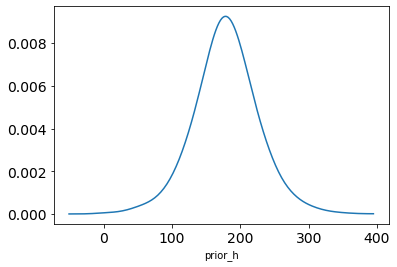

In [11]:
az.plot_kde(prior_h)
plt.xlabel('prior_h')


##### code 4.14. 
##### notice that here, we use log probabilities, instead of probabilities
##### 

In [12]:
#mu_list = np.linspace(140, 160, num=200)
#sigma_list = np.linspace(4, 9, num=200)
#mu_axis, sigma_axis = np.meshgrid(mu_list, sigma_list)
# it seems that np.mgrid is preferred over np.meshgrid, see http://louistiao.me/posts/numpy-mgrid-vs-meshgrid/#id2

In [13]:
post = np.mgrid[140:160:200j, 4:9:200j].reshape(2, -1).T #notice that we need to use mgrid[], instead of ()

In [14]:
log_likelihood = [np.sum(norm.logpdf(df2.height, loc=post[:,0][i], scale=post[:,1][i])) for i in range(len(post))]
log_posterior = log_likelihood + norm.logpdf(post[:, 0], loc=178, scale=20) + uniform.logpdf(post[:, 1], loc=0, scale=50)
posterior = np.exp(log_posterior - max(log_posterior))

In [15]:
posterior_df = pd.DataFrame([post[:, 0],post[:, 1], posterior]).T
posterior_df.columns = ["mu", 'sigma', 'posterior']
posterior_df.head()

,mu,sigma,posterior
0,140.0,4.000000,0.0
1,140.0,4.025126,0.0
2,140.0,4.050251,0.0
3,140.0,4.075377,0.0
4,140.0,4.100503,0.0


##### ! I skip the contour map here (i.e., 4.15, and 4.16). 

##### code 4.17~4.18

In [16]:
sample_rows = np.random.choice(np.arange(len(posterior)), size=int(1e4), replace=True, p=posterior/posterior.sum())

In [17]:
sample_mu = posterior_df.iloc[sample_rows, 0]
sample_sigma = posterior_df.iloc[sample_rows, 1]

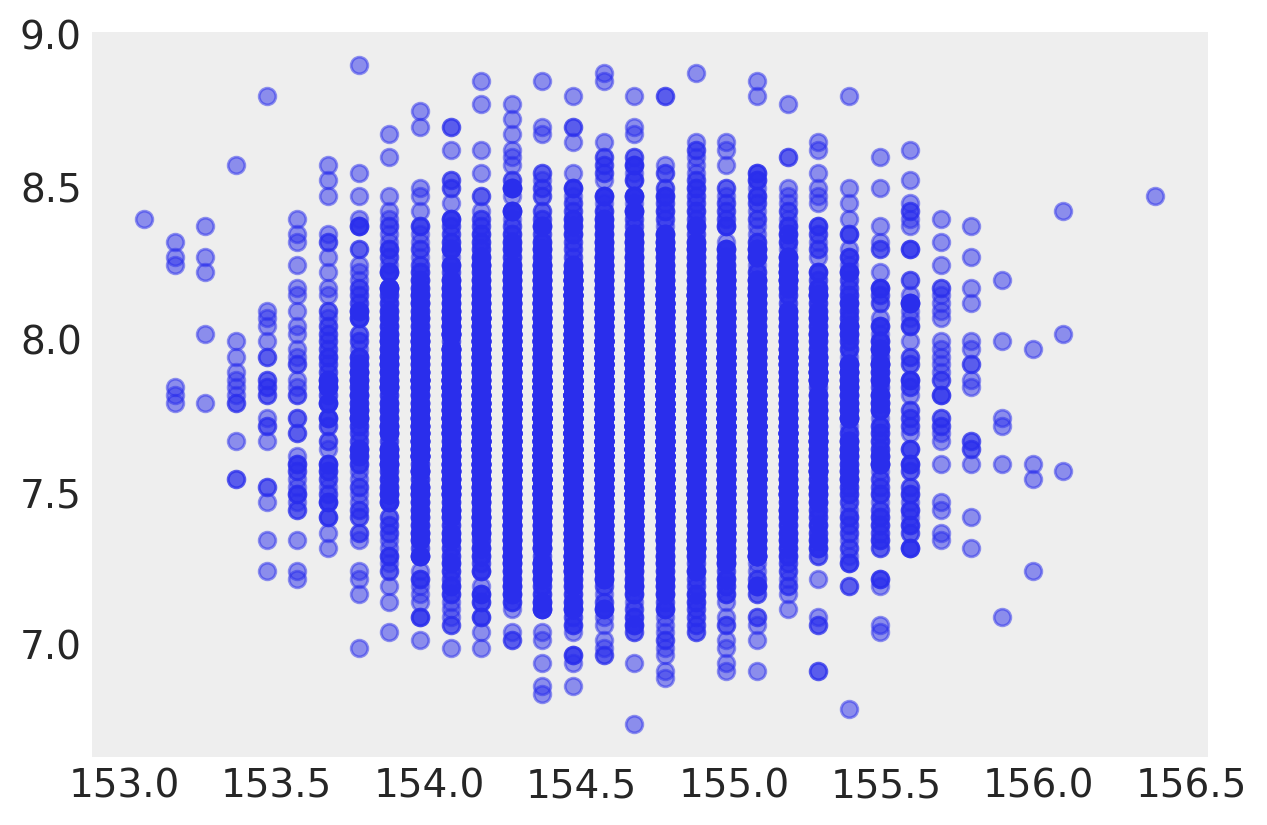

In [18]:
%config InlineBackend.figure_format = 'retina'
az.style.use('arviz-darkgrid')
plt.scatter(sample_mu, sample_sigma, marker='o', alpha=0.5)
plt.axis('equal')
plt.grid(False)

### use pymc3 to fit the model (4.3.5)

In [19]:
with pm.Model() as model: # model specifications in PyMC3 are wrapped in a with-statement
    # Define priors
    mu = pm.Normal('mu', mu=178, sigma=20)
    sigma = pm.Uniform('sigma', lower=0, upper=50)

    # Define likelihood
    likelihood = pm.Normal('height', mu=mu,
                        sigma=sigma, observed=df2.height)

    # Inference!
    trace = pm.sample(3000, cores=2) # draw 3000 posterior samples using NUTS sampling

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, mu]
Sampling 2 chains, 0 divergences: 100%|██████████| 7000/7000 [00:04<00:00, 1584.79draws/s]


##### code 4.26~4.27 maximum a posteriori

In [20]:
map_estimate = pm.find_MAP(model=model)
map_estimate


logp = -1,235.2, ||grad|| = 11.697: 100%|██████████| 19/19 [00:00<00:00, 2911.43it/s]  


{'mu': array(154.60702358),
 'sigma_interval__': array(-1.69876478),
 'sigma': array(7.73133303)}

##### code 4.29 a more informative prior

In [21]:
with pm.Model() as model_1: # model specifications in PyMC3 are wrapped in a with-statement
    # Define priors
    mu = pm.Normal('mu', mu=178, sigma=0.1)
    sigma = pm.Uniform('sigma', lower=0, upper=50)

    # Define likelihood
    likelihood = pm.Normal('height', mu=mu,
                        sigma=sigma, observed=df2.height)

    # Inference!
    trace = pm.sample(3000, cores=2)

map_estimate_1 = pm.find_MAP(model=model_1)
map_estimate_1

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, mu]
Sampling 2 chains, 0 divergences: 100%|██████████| 7000/7000 [00:04<00:00, 1577.04draws/s]
logp = -1,630.1, ||grad|| = 14.075: 100%|██████████| 7/7 [00:00<00:00, 2781.11it/s]


{'mu': array(177.86375428),
 'sigma_interval__': array(-0.03860064),
 'sigma': array(24.51755186)}

##### notice that az.summary() is very useful!

In [22]:
az.summary(trace, credible_interval=.89).round(2)

,mean,sd,hpd_5.5%,hpd_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
mu,177.86,0.10,177.71,178.03,0.00,0.00,5549.0,5549.0,5533.0,4294.0,1.0
sigma,24.60,0.94,23.20,26.18,0.01,0.01,5248.0,5203.0,5285.0,3822.0,1.0


##### 4.3.6 sampling from map fit
##### code 4.30

In [23]:
df_trace = pm.backends.tracetab.trace_to_dataframe(trace)  #notice that .trace_to_dataframe() method is not clearly mentioned in the documentation, yet it works
df_trace.cov()

,mu,sigma
mu,0.010628,0.010730
sigma,0.010730,0.879214


#### 4.4 Adding a predictor

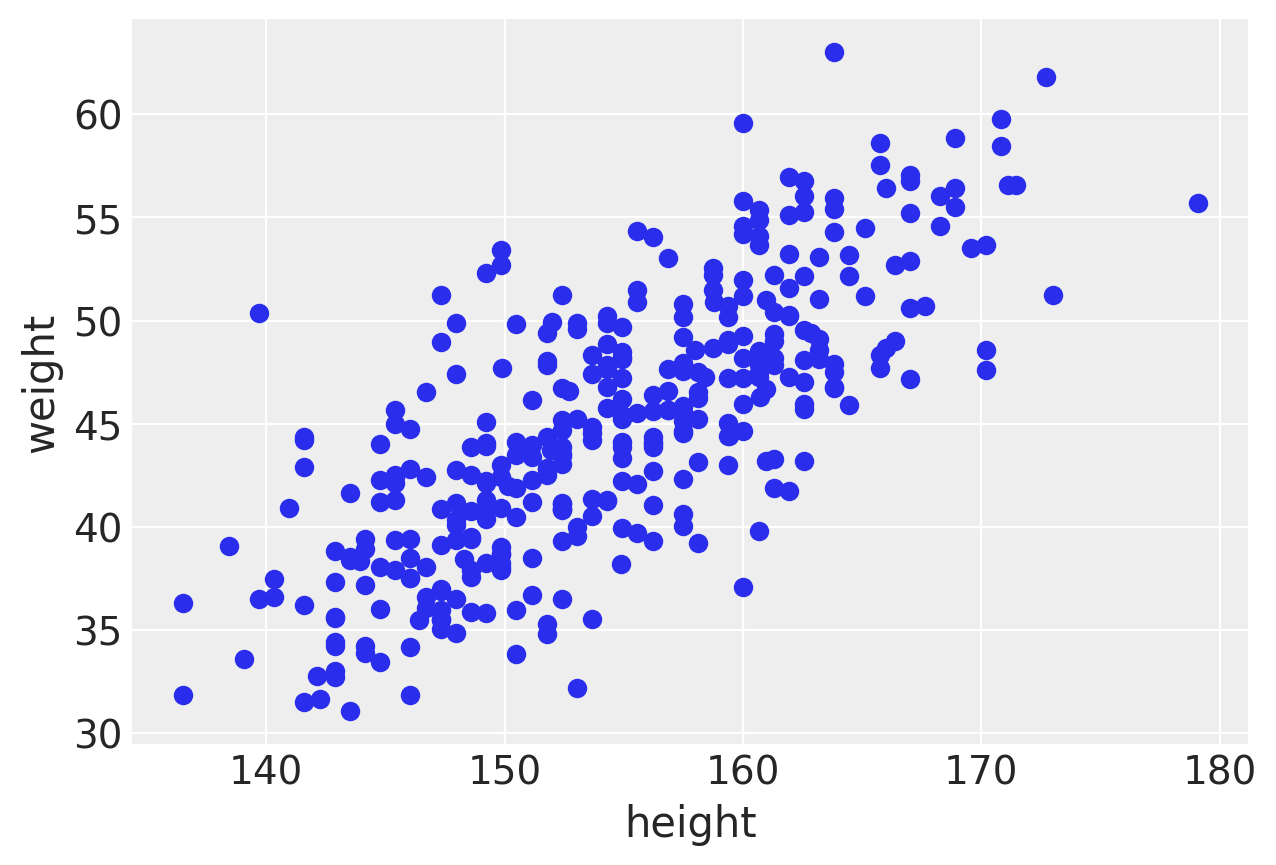

In [24]:
plt.scatter(df2.height, df2.weight)
plt.xlabel('height')
plt.ylabel('weight')
plt.show()

##### code 4.38

In [25]:
with pm.Model() as model_438: # model specifications in PyMC3 are wrapped in a with-statement
    # Define priors
    alpha = pm.Normal('alpha', mu=178, sigma=100)
    beta = pm.Normal('beta', mu=0, sigma=10)
    sigma = pm.Uniform('sigma', lower=0, upper=50)

    mu = alpha + beta * df2.weight
    # Define likelihood
    likelihood = pm.Normal('height', mu=mu,
                        sigma=sigma, observed=df2.height)

    # Inference!
    trace = pm.sample(3000) # draw 3000 posterior samples using NUTS sampling



Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta, alpha]
Sampling 4 chains, 0 divergences: 100%|██████████| 14000/14000 [00:15<00:00, 890.54draws/s] 
The acceptance probability does not match the target. It is 0.8918295676948916, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8848255278931837, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8852343246125204, but should be close to 0.8. Try to increase the number of tuning steps.


/Users/zhengguo/.pyenv/versions/3.8.0/lib/python3.8/site-packages/arviz/plots/backends/matplotlib/distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
/Users/zhengguo/.pyenv/versions/3.8.0/lib/python3.8/site-packages/arviz/plots/backends/matplotlib/distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
/Users/zhengguo/.pyenv/versions/3.8.0/lib/python3.8/site-packages/arviz/plots/backends/matplotlib/distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x12a4a6790>,
      dtype=object)

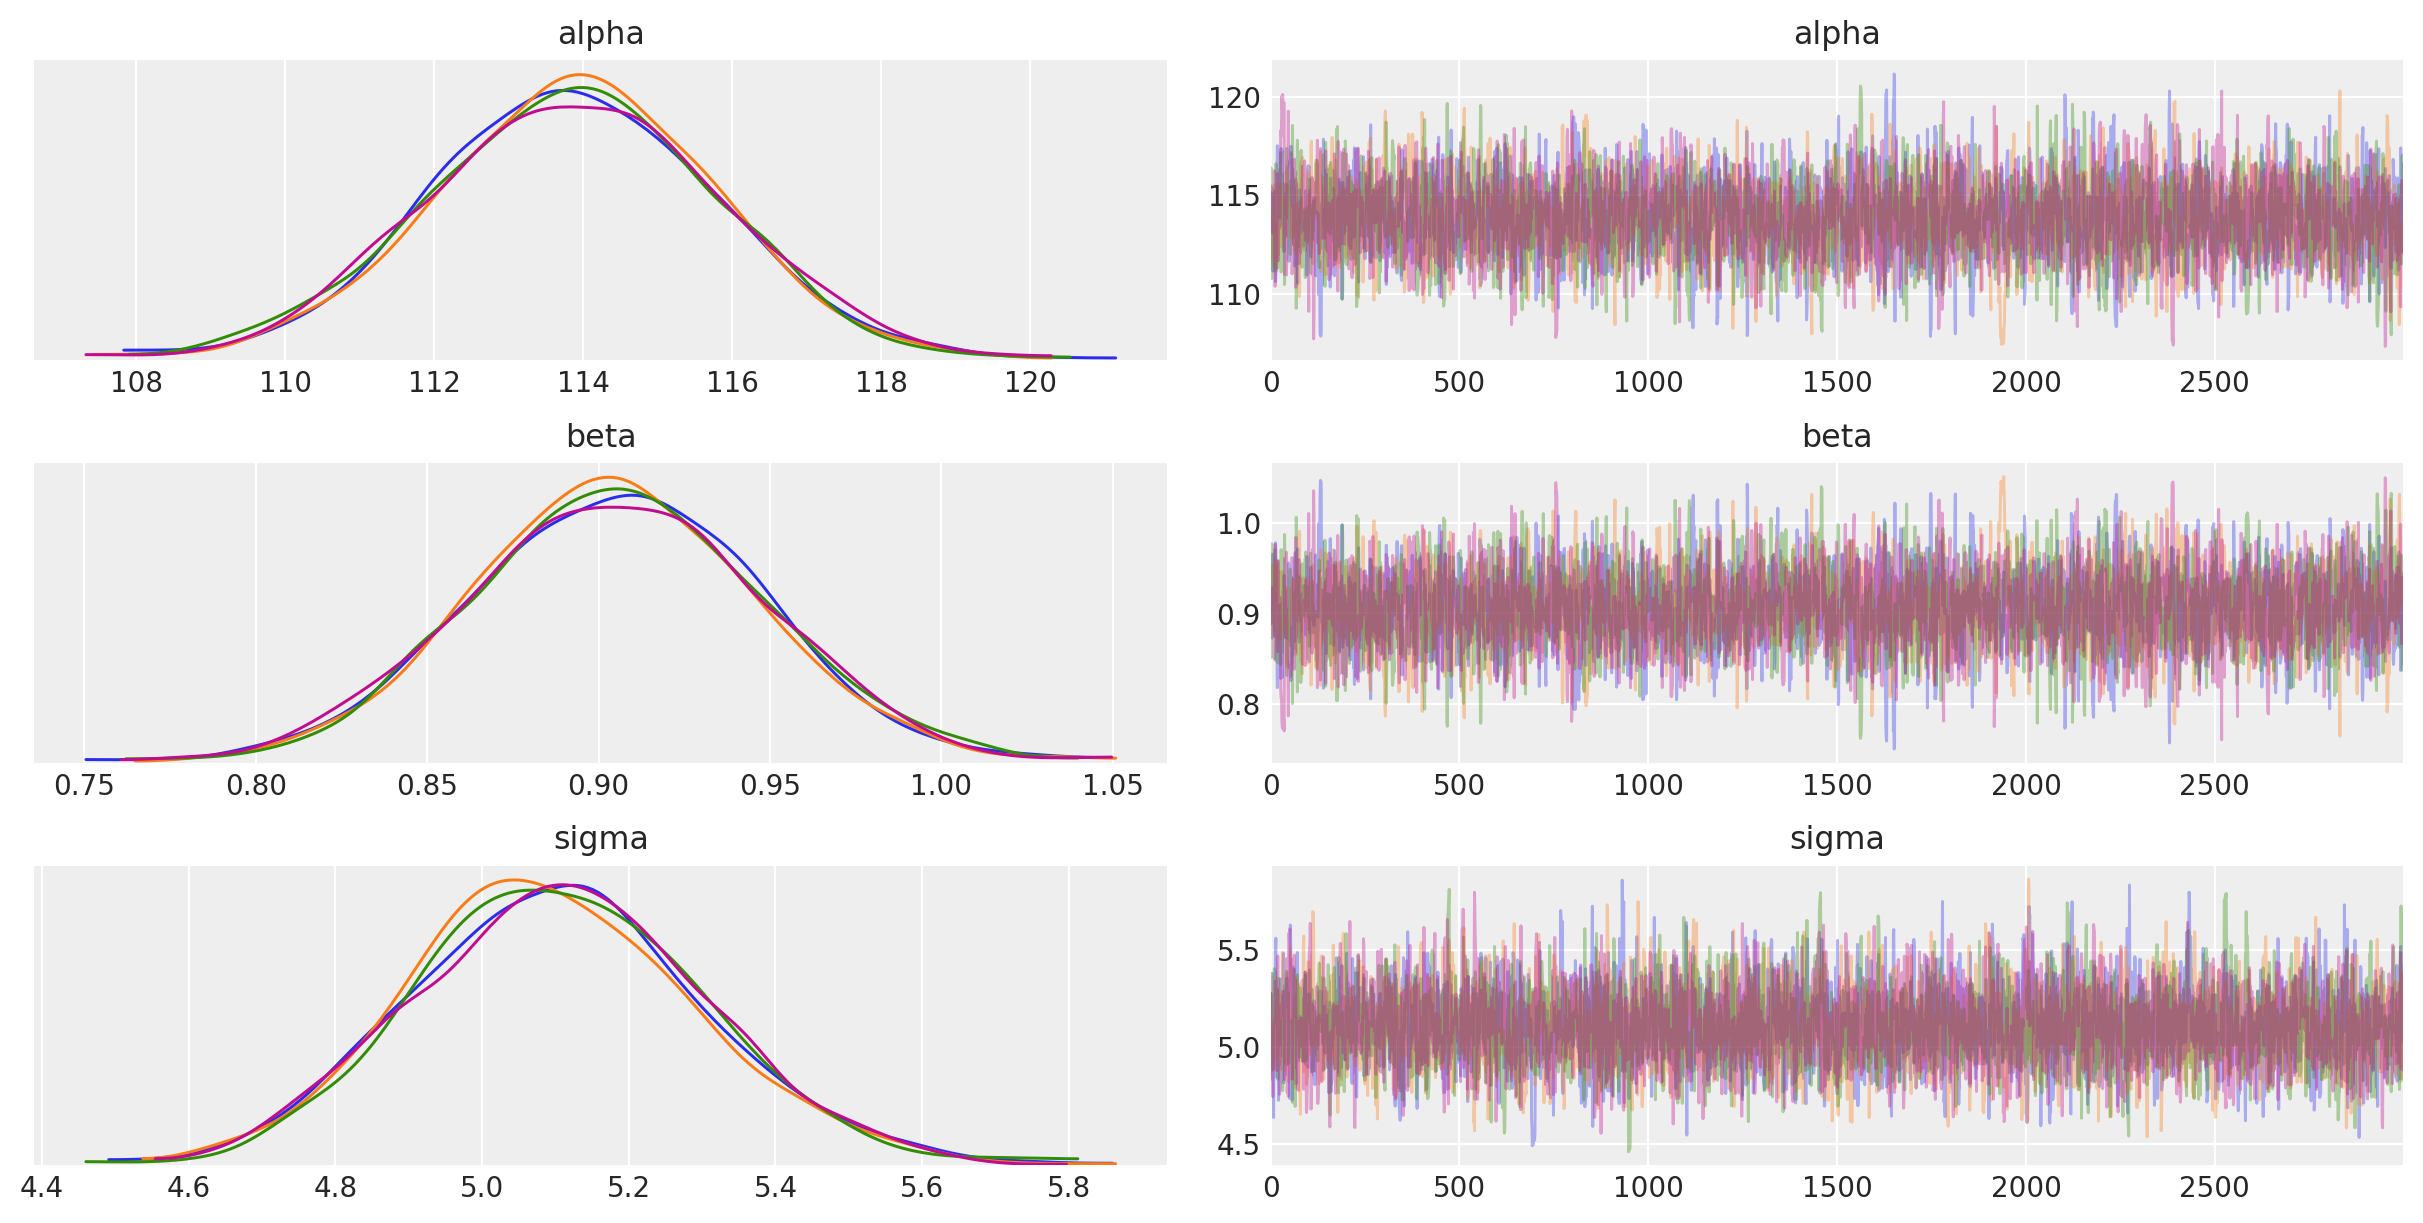

In [26]:
pm.traceplot(trace)

In [28]:
az.summary(trace, credible_interval=.89)


,mean,sd,hpd_5.5%,hpd_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
alpha,113.867,1.936,110.699,116.839,0.032,0.023,3669.0,3669.0,3681.0,3894.0,1.0
beta,0.905,0.043,0.838,0.973,0.001,0.000,3647.0,3636.0,3657.0,3989.0,1.0
sigma,5.104,0.197,4.781,5.409,0.003,0.002,4793.0,4747.0,4857.0,4324.0,1.0


In [32]:
trace_df = pm.trace_to_dataframe(trace)
trace_df.corr().round(2)
#notice that alpha and beta are highly negatively correlated, which is not good (in more complex models). 

,alpha,beta,sigma
alpha,1.00,-0.99,-0.01
beta,-0.99,1.00,0.01
sigma,-0.01,0.01,1.00


##### de-mean 

In [5]:
df2.weight = df2.weight - df2.weight.mean()


/Users/zhengguo/.pyenv/versions/3.8.0/lib/python3.8/site-packages/pandas/core/generic.py:5208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta, alpha]
Sampling 4 chains, 0 divergences: 100%|██████████| 14000/14000 [00:15<00:00, 902.21draws/s] 
The acceptance probability does not match the target. It is 0.9006000171760306, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8860045767091805, but should be close to 0.8. Try to increase the number of tuning steps.
/Users/zhengguo/.pyenv/versions/3.8.0/lib/python3.8/site-packages/arviz/plots/backends/matplotlib/distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
/Users/zhengguo/.pyenv/versions/3.8.0/lib/python3.8/site-packages/arviz/plots/backends/matplotlib/distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  wa

,mean,sd,hpd_5.5%,hpd_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
alpha,113.975,1.944,110.772,117.061,0.033,0.023,3471.0,3460.0,3494.0,3736.0,1.0
beta,0.903,0.043,0.834,0.972,0.001,0.001,3472.0,3472.0,3499.0,3640.0,1.0
sigma,5.112,0.197,4.792,5.421,0.003,0.002,5308.0,5303.0,5309.0,5457.0,1.0


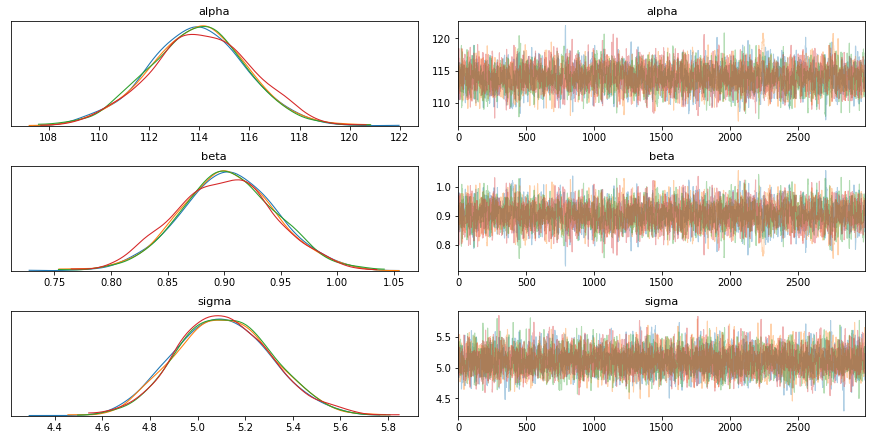

In [3]:
with pm.Model() as model_443: # model specifications in PyMC3 are wrapped in a with-statement
    # Define priors
    alpha = pm.Normal('alpha', mu=178, sigma=100)
    beta = pm.Normal('beta', mu=0, sigma=10)
    sigma = pm.Uniform('sigma', lower=0, upper=50)

    mu = alpha + beta * df2.weight
    # Define likelihood
    likelihood = pm.Normal('height', mu=mu,
                        sigma=sigma, observed=df2.height)

    # Inference!
    trace_443 = pm.sample(3000) # draw 3000 posterior samples using NUTS sampling

pm.traceplot(trace_443)

az.summary(trace_443, credible_interval=.89)


In [4]:
trace_df = pm.trace_to_dataframe(trace_443)
trace_df.corr().round(2)

#notice that predictor weight is de-meaned, as a result, the estimated alpha and beta are not correlated anymore, 
# this is because of the de-mean: now alpha means that when predictor = 0, which happens to be the average weight. 

,alpha,beta,sigma
alpha,1.00,-0.99,-0.0
beta,-0.99,1.00,0.0
sigma,-0.00,0.00,1.0


In [6]:
alpha_hat = trace_443['alpha'].mean()  #notice that this mean is just the mean in the table
beta_hat = trace_443['beta'].mean()

In [7]:
print(alpha_hat, beta_hat)

113.97541132367637 0.9029560876933614


In [ ]:
fig, bayesian = plt.subplots(figsize=(10, 6))
bayesian.scatter(df2.weight, df2.height)
bayesian.plot(df2.weight, alpha_hat + beta_hat * df2.weight)